# This repository contains tools for single cell simulations in barrel cortex.

## Setup
 1. download and install Anaconda 2.7 https://www.continuum.io/Downloads
 2. install neuron such that you can import it as python module. Version 7.4 has been tested, newer versions are likely to work. Detailed installation instructions can be found at http://www.davison.webfactional.com/notes/installation-neuron-python/
 3. Add the neuron folder to your PATH environment variable, such that you can run `nrnivmodl` anywhere
 3. install the following dependencies:
    - sumatra, *used for parameterfiles*: `pip install sumatra`
    - pandas 0.19.2, *data analysis library*: `conda install pandas==0.19.2`
    - dask 0.14.2, *dynamic task scheduling and "big data" extension of pandas*: `conda install dask==0.14.2`
    - distributed 1.15.2 *allows non-bloccking computations and brings dask to a cluster*: `conda install distributed=1.15.2`
    - seaborn: *statistical data visualization*: `conda install seaborn`
    - fasterners: *robust file based locking*: `pip install fasteners`
    - jinja2: *html template engine, required for embedded animations*: `pip install jinja2`
 4. clone or pull this repository: `git clone https://github.com/abast/in_silico_framework.git`. 
 5. add your in_silico_framework folder to the PYTHONPATH variable
 6. unzip the following folder: in_silico_framework/getting_started/barrel_cortex.zip such that the following file exists: `in_silico_framework/getting_started/barrel_cortex/nrCells.csv`
 7. run the test suite: `python run_tests.py`. 
 
 Due to the statistical nature of the cortex model, some tests might fail from time to time. These tests have the word _statistical_ in their description. If such a test fails, run the testsuite again. If that test fails again, there most likely is an issue. Tests, that do not have a _statistical_ flag in their description may never fail.

## Packages in this repository you will most likely directly interact with
**single_cell_input_mapper**: Module for generating anatomical models, i.e. determining number and location of synapses and number and location of presynaptic cells

**single_cell_parser**: High level interface to the NEURON simulator providing methods to perform single cell simulations with synaptic input. The anatomical constraints of the synaptic input are provided by the single_cell_input_mapper module.

**simrun2**: high level interface to the single_cell_parser module providing methods for common simulation tasks. It also provides methods for building reduced models mimicing the full compartmental model.

**model_data_base**: flexible database whose API mimics a python dictionary. It provides efficient and scalable methods to store and access simulation results at a terrabyte scale. It also generates metadata, indicating when the data was put in the database and the exact version of the in_silico_framework that was used at this timepoint. Simulation results from the single_cell_parser module can be imported and converted to a high performance binary format. Afterwards the data is accessible using the pandas data analysis library and dask. 

**single_cell_analyzer**: library for analysis of single_cell_parser results. Use this module, if you specifically want to analyze a single simulation run. If you want to analyze the results of many simulation trails, the recomended way is to import the simulation results in a model_data_base and use pandas and dask for the analysis afterwards.

## Other packages

**mechanisms**: NEURON mechanisms (Ion channels, synapses, ...) used by the neuron simulator. If you run `import mechanisms`, these mechanisms are beeing compiled. Make sure, that you have the nrnivmodl executable in your path, otherwise this will not work

**test_simrun2, test_model_data_base, ...**: tests for the respective modules. They can be run by calling `python run_tests.py`

## How should I interact with these packages?

The recommended way is to use the `Interface` module which glues together all these packages mentioned above to one *Application*: It provides the API necessary to perform simulation tasks and provides additional methods that improve interactivity.

In [1]:
import Interface as I

Current version: v0.0.1+94.g8d54a85.dirty
Current pid: 16085
Loading mechanisms:
setting up local multiprocessing framework ... done


/nas1/Data_arco/project_src/in_silico_framework/Interface.py:154: UserWarning: The source folder has uncommited changes!
  if get_versions()['dirty']: warnings.warn('The source folder has uncommited changes!')


Now, you can access the relevant packages without the need to import them seperately:

In [3]:
I.scp # single_cell_parser package
I.sca # single_cell_analyzer package
I.ModelDataBase # main class of model_data_base
I.map_singlecell_inputs # compute anatomical model for a given cell morphology in barrel cortex 
I.simrun_run_new_simulations # default function for running single cell simulations with well constrained synaptic input
I.mdb_init_simrun_general.init # default method to initialize a model data base with existing simulation results
I.mdb_init_simrun_general.optimize # converts the data to speed optimized compressed binary format
I.synapse_activation_binning_dask # parallelized binning of synapse activation data
I.rm_get_kernel # create reduced lda model from simulation data

I.silence_stdout # context manager and decorator to silence functions
I.cache # decorator to cache functions

I.cluster() # get distributed.Client() object for parallel execution

I.np # numpy
I.pd # pandas
I.dask # dask
I.distributed # distributed
I.sns # seaborn
# ...

<module 'seaborn' from '/nas1/Data_arco/prgr/Anaconda2/lib/python2.7/site-packages/seaborn/__init__.pyc'>

Use autocompletion of IPython to find the other modules. To view the documentation, use a questionamrk, e.g.

In [37]:
I.mdb_init_simrun_general.init?

# Quickstart: How to run a simulation?

To run single cell simulations, we first need a hoc morphology file of that cell. Additionally, we need to know, how to distribute ion channels on that morphology, such that the cell has the desired biophysical properties. 

In the getting started subfolder of this repository, there is such a hoc-morphology and the corresponding parameter file. 
    - anatomical_constraints/86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center.hoc
    - biophysical_constraints/86_CDK_20041214_BAC_run5_soma_Hay2013_C2center_apic_rec.param
    
**Let's have a closer look at the parameters.**
    

In [3]:
from getting_started import getting_started_dir # path to getting started folder
cell_param = I.os.path.join(getting_started_dir, \
                            'biophysical_constraints', \
                            '86_CDK_20041214_BAC_run5_soma_Hay2013_C2center_apic_rec.param')
cell_param = I.scp.build_parameters(cell_param) # this is the main method to load in parameterfiles

`cell_param` is a nested dictionary. The biophysical parameters are described in the *neuron* key. Here, we specify ion channel conductances for all structures of the cell:

In [4]:
cell_param.neuron.keys()

['Myelin', 'Soma', 'AIS', 'filename', 'Dendrite', 'ApicalDendrite']

The key *filename* points to the hoc morphology file. The others define ion channel conductances for the respective part of the cell. Let's figure out, what channels can be found in the basal dendrite:

In [43]:
cell_param.neuron.Dendrite

{'mechanisms': {'global': {},
  'range': {'Ih': {'gIhbar': 0.0002, 'spatial': 'uniform'},
   'pas': {'e': -90.0, 'g': 6.31e-05, 'spatial': 'uniform'}}},
 'properties': {'Ra': 100.0, 'cm': 2.0}}

Here you see that we only have the passive conductance and If channels, both uniformly distributed along the dendrite. There are much more channels in the apical dendrite. A comprehensive description of the other parts of the cell parameter file can be found here: #todo

## **Now, we can do some current injection experiments to analyze the biophysical properties of the model.** 

In [6]:
# set up cell. This creates a lot of (interesting) diagnostic output. Remove the context manager to see it
with I.silence_stdout:
    cell = I.scp.create_cell(cell_param.neuron)

Let's figure out some general properties of the cell

In [5]:
print 'total length = {:.0f} micron'.format(sum([sec.L for sec in cell.sections]))
print 'total dendritic length = {:.0f} micron'.format(sum([sec.L for sec in cell.sections \
                                                           if sec.label in ['Soma', 'Dendrite', 'ApicalDendrite']]))
print 'soma area = {:.0f} micron^2'.format(sum([sec.area for sec in cell.sections if sec.label == 'Soma']))
print 'apical dendrite area = {:.0f} micron^2'.format(sum([sec.area for sec in cell.sections \
                                                           if sec.label == 'ApicalDendrite']))

total length = 16340 micron
total dendritic length = 15290 micron
soma area = 916 micron^2
apical dendrite area = 16855 micron^2


The respective hoc morphology has a very thin apical dendrite which does not allow electric coupling between apical dendrite and soma. We figured that it is necessary to scale up the diameter of the trunc.

In [44]:
# load scaled hoc morphology
cell_param.neuron.filename = I.os.path.join(getting_started_dir, 'anatomical_constraints', \
                            '86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_scaled_diameters.hoc')
with I.silence_stdout:
    cell = I.scp.create_cell(cell_param.neuron)
print 'apical dendrite area = {:.0f} micron^2'.format(sum([sec.area for sec in cell.sections \
                                                           if sec.label == 'ApicalDendrite']))

apical dendrite area = 27212 micron^2


Now, we put a pipette at the soma of the cell and inject a short rectangular current

In [45]:
import neuron
h = neuron.h

In [8]:
iclamp = h.IClamp(0.5, sec=cell.soma)
iclamp.delay = 150 # give the cell time to reach steady state
iclamp.dur = 5 # 5ms rectangular pulse
iclamp.amp = 1.9 # 1.9 ?? todo ampere

CPU times: user 2.65 s, sys: 0 ns, total: 2.65 s
Wall time: 2.66 s


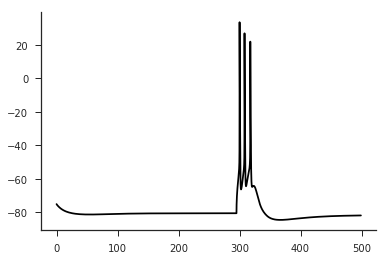

In [36]:
%time I.scp.init_neuron_run(cell_param.sim, vardt=True) # run the simulation 
%matplotlib inline
I.sns.set_style('ticks')
I.plt.plot(cell.tVec, cell.soma.recVList[0], c = 'k')
I.sns.despine()

How does the cell respond to different amplitudes of the step current?

In [11]:
cell_param.sim.tStop = 3000
iclamp.dur = 2000
iclamp.delay = 500
simresult = {}
for amp in [0.619, 0.793, 1.507]:
    iclamp.amp = amp
    I.scp.init_neuron_run(cell_param.sim, vardt=True)
    simresult[amp] = cell.tVec, cell.soma.recVList[0]

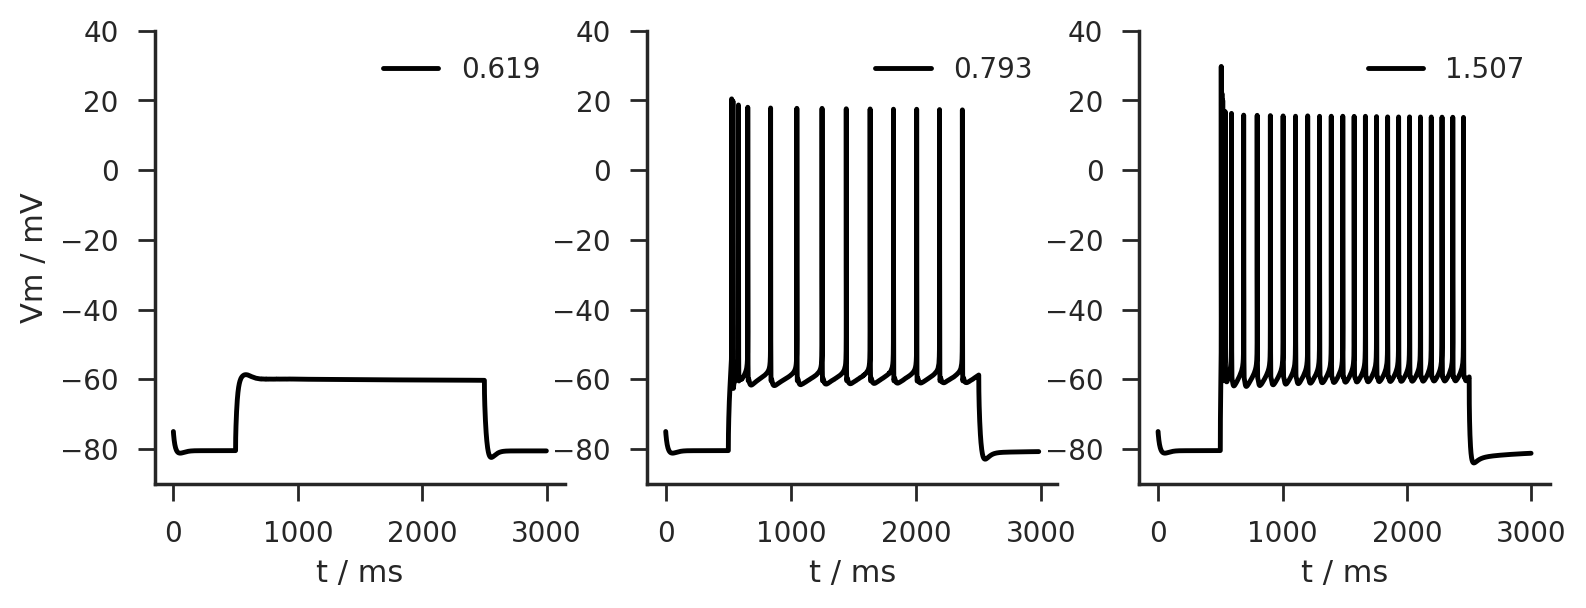

In [13]:
fig = I.plt.figure(figsize = (9,3), dpi = 200)
for lv, k in enumerate(sorted(simresult.keys())):
    ax = fig.add_subplot(1,3,lv+1)
    ax.plot(*simresult[k], label = k, c = 'k')
    ax.legend(loc = 'upper right')
    ax.set_ylim([-90, 40])
    ax.set_xlabel('t / ms')
    if lv == 0:
        ax.set_ylabel('Vm / mV')
I.sns.despine()

Now let's place a pipette on the apical trunk at a soma distance of 620 microns and inject current synchronously at this position and at the soma. For the current at the soma, we choose a rectangular pulse again. The current at the apical injection site should resemble the shape of a evoked post synaptic potential (epsp). Have a look at the folder mechanisms/synapses to see how epsp is implemented in hoc code.

In [9]:
# map between sections and somadistance
sec_dist_dict = {cell.distance_to_soma(sec, 1.0): sec for sec in cell.sections}

def get_section_at_distance(cell, dist):
    dummy = {k - dist: v for k,v in sec_dist_dict.iteritems() if k > dist}
    closest_sec = dummy[min(dummy)]
    x = (dist - cell.distance_to_soma(closest_sec, 0.0)) / closest_sec.L
    return x, closest_sec

In [10]:
cell_param.sim.tStop = 500
x, sec = get_section_at_distance(cell, 620)

iclamp = h.IClamp(0.5, sec=cell.soma)
iclamp.delay = 295 # give the cell time to reach steady state
iclamp.dur = 5 # 5ms rectangular pulse
iclamp.amp = 1.9 # 1.9 ?? todo ampere

iclamp2 = h.epsp(x, sec=sec)
iclamp2.onset = 300
iclamp2.imax = 0.5
iclamp2.tau0 = 1.0 # rise time constant
iclamp2.tau1 = 5 # decay time constant
cell.iclamp2 = iclamp2

%time I.scp.init_neuron_run(cell_param.sim, vardt=True) # run the simulation 

CPU times: user 2.55 s, sys: 8 ms, total: 2.56 s
Wall time: 2.57 s


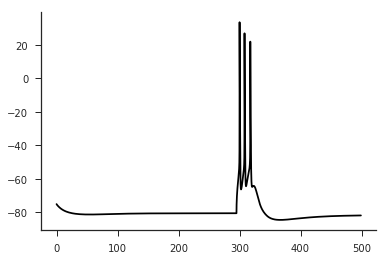

In [37]:
I.plt.plot(cell.tVec, cell.soma.recVList[0], c = 'k')
I.sns.despine()

So far, we have only visualized the somatic membrane potential. Now, we create a short animation, where the whole dendrite is visualized (x-axis: soma distance of dendrite segment, y-axis: Vm)

In [12]:
mdb = I.ModelDataBase('/home/abast/my_mdb/') # create a ModelDataBase to save paths to the animation files

see section [ModelDataBase](#ModelDataBase) for a more detailed descritpion

In [18]:
if not 'burst_trail_video' in mdb.keys():
    I.scp.init_neuron_run(cell_param.sim, vardt=False) # fixed step size necessary for animation
    mdb['burst_trail_video'] = I.cell_to_animation(cell, \
                                                            xlim = [0,1500], \
                                                            ylim = [-90, 50], \
                                                            tstart = 295, \
                                                            tend = 350, \
                                                            tstep = 0.2)
I.display_animation(mdb['burst_trail_video'])    

files are here: animation/animation_e4V2zg/*.png


We can also visualize current through ion channels. Let's have a look at the calcium current through low voltage activated calcium channels:

In [32]:
if not 'burst_trail_ca_current_video' in mdb.keys():
    cell.record_range_var('Ca_LVAst.ica') # have a look at the mechanisms folder to find available range vars
    I.scp.init_neuron_run(cell_param.sim, vardt=False)
    mdb['burst_trail_ca_current_video'] = I.cell_to_animation(cell, \
                                                            xlim = [0,1500], \
                                                            ylim = [-90, 50], \
                                                            tstart = 295, \
                                                            tend = 350, \
                                                            tstep = 0.2,\
                                                            range_vars = 'Ca_LVAst.ica')
I.display_animation(mdb['burst_trail_ca_current_video'])   


# ModelDataBase
<a id='ModelDataBase'></a>

This section documents the API of the ModelDataBase class

First, we create a model data base as central storage place

In [26]:
mdb = I.ModelDataBase('/home/abast/my_mdb/')

We can use the mdb object like a dictionary. However, all data will be instantly saved to / loaded from disk:

In [38]:
mdb['something'] = 'some text i want to save'
mdb['something']

'some text i want to save'

The model data base also stores metadata for each item about the time and exact `in_silico_framework` version used at creation time. You can access metadata of *something* in the following way:

In [39]:
mdb.metadata['something']

defaultdict(<function model_data_base.model_data_base.<lambda>>,
            {'dirty': True,
             'dumper': 'to_cloudpickle',
             'error': None,
             'full-revisionid': '8d54a85af82bf3a1893a6cc70140052ae9735edf',
             'metadata_creation_time': 'together_with_new_key',
             'time': (2017, 11, 11, 18, 15, 57, 5, 315, -1),
             'version': 'v0.0.1+94.g8d54a85.dirty'})

The most relevant parts here are:
    - dumper: the method how the data was saved in the database
    - time: Timepoint (UTC) when the data was added
    - version: version of the in_silico_framework repository at the timepoint the data was added
    - dirty: whether there where uncommited changes at the timepoint the data was added

You can access the code that was used to save the data in the model data base:
https://github.com/abast/in_silico_framework/tree/[full_revisionid]

By default, the ModelDataBase uses cloudpickle to store data on disk ('dumper': 'to_cloudpickle'). While this allows to store arbitrary python objects, it is not well suited for large datasets. For these cases, you can choose different methods to store the data:

 - **I.dumper_to_pickle**: this uses cPickle to serialize aribtrary python objects. While this is faster than cloudpickle, it only works for a much more limited set of python objects compared to cloudpickle.
 - **I.dumper_pandas_to_pickle**: saves a pandas dataframe using pandas [to_pickle](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_pickle.html) method.
 - **I.dumper_pandas_to_msgpack**: saves a pandas dataframe using pandas [to_msgpack](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_msgpack.html) method with blosc compression. This usually provides the best performance.
 - **I.dumper_dask_to_csv **: saves a dask dataframe to csv. Each partition is stored as csv file using the pands [to_csv](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_csv.html) method. If the dataframe has more than 10000 partitions, it is repartitioned to 5000 partitions (i.e. the data is saved with not more than 10000 chunks). Metadata (dtypes, column names, ...) is stored seperately.
 - **I.dumper_dask_to_msgpack**: saves dask dataframe to msgpack. Each partition is stored as csv file using the pandas [to_msgpack](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_msgpack.html) method with blosc compression. If the dataframe has more than 10000 partitions, it is repartitioned to 5000 partitions (i.e. the data is saved with not more than 10000 chunks).
 - **I.dumper_dask_to_categorized_msgpack**: This method is similar to I.dumper_dask_to_msgpack, however, before storing the data, it is preprocessed: All columns of dtype 'object' (i.e. the all columns containing strings including the index) are categorized, which means, repeated occurences of the same string value are replaced by integer values. This allows to compress dataframes containing lots of repeated string values much better.
 - **I.dumper_numpy_to_npy**: This method can be used to store numpy arrays.
 - **I.dumper_cell**: this saves a single_cell_parser.Cell object by first replacing all neuron.Vector instances with numpy.array and afterwards using pickle to save it to disk. 
 - **'self'**: save objects directly to the backend sqlite database. Don't use it for large objects, since writing to the database blocks it for other processes.



To specify a dumper, the syntax mdb['someting'] = ... is not powerfull enough. Use mdb.setitem instead:

In [29]:
# this is the same as mdb['something'] = 'some text i want to save'
mdb.setitem('something', 'some text i want to save', dumper = I.dumper_to_cloudpickle) 

Not documented yet:
    - model_data_base_register
    - get_id()
    - mdb://[unique_id]/path
    - create sub_mdb
    - create managed folder
    - maybe_calculate

### how model data base works internally

If we put data in the database, a subdirectory is created. The foldername is the key (reduced to characters supported by the file system) plus some random suffix.

In [41]:
print I.os.listdir(mdb.basedir)

['dbcore.pickle', 'sqlitedict.db.lock', 'sqlitedict.db', 'metadata.db.lock', 'metadata.db', 'burst_trail_video_He6P9E_', 'burst_trail_ca_current_video_r9fSGP_', 'something_F6bt2F_']


Then, the dumper is called with the data and the path to that subfolder. It saves the data in the subfolder together with a Loader.pickle file. The Loader.pickle file contains an object, which is defined in the same module as the dumper. The Loader-object contains all information necessary to load in the data. It provides a get-method. Then, the key is saved in the sqlite database, together with the name of the subfolder. Metadata is saved accordingly.

To load the data, the foldername is requested from the sqlite database. Afterwards, the Loader.pickle file is loaded and the get-method is called with the absolute path to the respective subfolder. If the database is moved from one location to another, the absolute path is automatically adapted, i.e. the ModelDataBase object takes care of it, while the get method may rely on absolute paths.

Reading and writing to sqlite is handled by the class _sql_backend. Since the locking mechanism of sqlite is not safe on nfs mounts, an additional file based locking mechanism has been implemented. Currently, we only allow sequential reading and writing. If the model data base is used on a large cluster, this does not have a substantial impact on the overall performance, as long as the access time to the database per process is small. Since all dumpers listed above (except 'self') only write a small amount of data to sqlite (i.e. the key and the subfolder), this does not impact performance.

Using  = 'self' is discouraged. Reasons:  All dumpers except 'self' only save the path to the subfolder in sqlite (short access time), while the dumper 'self' stores the whole python object there (can require to open a sql connection for a long time, blocking access for other processes).

Currently, sqlite is not used directly, instead the module tuplecloudsqlitedict is used. Opposite to sqlite, this is thread-safe. Also, it allows to save python objects directly to the sqlite database (this is, what enables dumper = 'self'). 

Todo: Get rid of tuplecloudsqlitedict and the dumper 'self'

## Simulations with well-constrained synaptic input

### Register cell morphology
The coordinates in the hoc morphology file need to be choosen according to the coordinate system of the barrel cortex model. There is a morphology file in the getting_started subfolder, which is registered such that the cell is in the center of the C2 column. For the following steps, this morphology is used.

### Generate anatomical model

To integrate the registered cell morphology in the barrel cortex model, you need the SingleCellInputMapper repository. The script map_singlecell_inputs only needs two inputs: the path to the registered hoc morphology and the celltype.

In [20]:
sys.path.insert(0,'/home/abast/test/SingleCellInputMapper/')
sys.path.insert(0,'/home/abast/test/model_data_base/')

In [21]:
import map_singlecell_inputs # core module of the SingleCellInputMapper repository
import Interface as I
# the singlecell input mapper is very talkative, therefore silence it.
silent_map_singlecell = lambda *args, **kwargs: I.silence_stdout(map_singlecell_inputs.map_singlecell_inputs, **kwargs)(*args)
#specify parameters
path_to_registered_hoc_morphology = os.path.join(getting_started_files, '86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center.hoc')
celltype = 'L5tt'

Now we can call the network mapper. The following code calculates the position of synapses onto the example cell. Under the hood, 50 network realizations will be calculated. Out of these, the one that is closest to the average is choosen. The result is saved in the same folder as the hoc morphology. This takes about ** 4 hrs to compute **, but you can continue with a precomputed result.

In [ ]:
silent_map_singlecell(path_to_registered_hoc_morphology, celltype)

##### How does the result of the map_singlecell_inputs script look like?
A precomputed result is in the folder model_data_base/getting_started_files/86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_synapses_20150504-1611_10389

The most important files are:
 - The  *_summary_*.csv file contains a summary statistics about the connectivity between all presynaptic populations and our neuron.
 - The *.con file and the *. syn file are the relevant output of the SingleCellMapper for simulations of evoked activity.

The con file maps between presynaptic cells and synapses:

In [18]:
with open(os.path.join(getting_started_files, '86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_synapses_20150504-1611_10389/86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_synapses_20150504-1611_10389/86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_synapses_20150504-1611_10389.con')) as f:
    print f.read()[:300]

# Anatomical connectivity realization file; only valid with synapse realization:
# 86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_synapses_20150504-1611_10389.syn
# Type - cell ID - synapse ID

L6cc_A3	0	0
L6cc_A3	1	1
L6cc_A3	2	2
L6cc_A3	3	3
L6cc_A3	4	4
L6cc_A3	4	5
L6cc_A3	5	6


The .syn file specifies the exact position of each synapse on the hoc morphology:

In [19]:
with open(os.path.join(getting_started_files, '86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_synapses_20150504-1611_10389/86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_synapses_20150504-1611_10389/86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_synapses_20150504-1611_10389.syn')) as f:
    print f.read()[:300]

# Synapse distribution file
# corresponding to cell: 86_L5_86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center
# Type - section - section.x

VPM_E1	112	0.138046479525
VPM_E1	130	0.305058053119
VPM_E1	130	0.190509288017
VPM_E1	9	0.368760777084
VPM_E1	110	0.0
VPM_E1	11	0.120662910562


##### Sidenote: how to parallelize it?
in case we would like to map the input on several cells in parallel, we could utilize dask to parallelize it using multiprocessing or a distributed cluster:

In [ ]:
# make the single cell mapper a delayed function
delayed_silent_map_singlecell = dask.delayed(silent_map_singlecell_outputs)
# call it with the morphologies
delayeds = [delayed_silent_map_singlecell_outputs(morphology_paths[p], 'L5tt') for p in morphology_paths]
# bundle everything in one delayed object
delayeds = dask.delayed(delayeds)
# compute the result, e.g. with the multiprocessing scheduler
delayeds.compute(get = dask.multiprocessing.get)
# or with the distributed scheduler:
import distributed
c = distributed.Client('my_server:8787', set_as_default = False)
delayeds.compute(get = c.get)

### Activate synapses
In the previous step, the synapse location on the hoc morphology was specified. Now we need to activate the synapses according to experimental data. Here, we generate a parameter file specifying the summary statistics of the activation of the presynaptic cells with 1ms resolution.

##### create nr_of_connected_cells spreadsheet

In [30]:
# Todo: this should become a part of the pipeline above
import generate_nr_of_cells_spreadsheet
con_file = os.path.join(getting_started_files, '86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_synapses_20150504-1611_10389/86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_synapses_20150504-1611_10389/86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_synapses_20150504-1611_10389.con')
cellNumberFileName = generate_nr_of_cells_spreadsheet.con_file_to_NumberOfConnectedCells_sheet(con_file)

##### specify parameters

In [32]:
import evoked_network_param_from_template #module that allows to generate parameterfile on how to activate the synapses
reload(evoked_network_param_from_template)
ongoingTemplateParamName = os.path.join(getting_started_files, 'functional_constraints/ongoing_activity/ongoing_activity_celltype_template_exc_conductances_fitted.param')
# cellNumberFileName: see cell above
syn_file = os.path.join(getting_started_files, '86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_synapses_20150504-1611_10389/86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_synapses_20150504-1611_10389/86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_synapses_20150504-1611_10389.syn')
con_file = os.path.join(getting_started_files, '86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_synapses_20150504-1611_10389/86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_synapses_20150504-1611_10389/86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_synapses_20150504-1611_10389.con')
whisker = 'C2' #simulate C2 stimulus. Since out cell is located in C2center, this is a principal whisker stimulation scenario.
evoked_up_param_name = os.path.join(getting_started_files, 'functional_constraints/network.param')
evoked_network_param_from_template.create_network_parameter(ongoingTemplateParamName, cellNumberFileName, syn_file, con_file, whisker, evoked_up_param_name)    

*************
creating network parameter file from template /home/abast/test/neurosim_getting_started/getting_started_files/functional_constraints/ongoing_activity/ongoing_activity_celltype_template_exc_conductances_fitted.param
*************


##### what does the result look like?

In [33]:
with open(evoked_up_param_name) as f:
    print f.read()[:4100]

{
  "info": {
    "date": "11Feb2015",
    "name": "ongoing_activity_up_state_anatomical_map_20150211-1430_22780",
    "author": "regger",
  },
  "network": {
    "L45Peak_D1": {
      "synapses": {
        "releaseProb": 0.25,
        "distributionFile": "/home/abast/test/neurosim_getting_started/getting_started_files/86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_synapses_20150504-1611_10389/86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_synapses_20150504-1611_10389/86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_synapses_20150504-1611_10389.syn",
        "receptors": {
          "gaba_syn": {
            "threshold": 0.0,
            "delay": 0.0,
            "parameter": {
              "decaytime": 20.0,
              "risetime": 1.0,
              "decaygaba": 1.0,
              "e": -80.0,
              "facilgaba": 0.0,
            },
            "weight": 1.0,
          },
        },
        "connectionFile": 

This file contains the activation pattern of every presynaptic population providing input to the single cell we want to simulate. One "population" in this case is one celltype in one column. Examples are: L45Peak_D1, L5tt_D2, L5tt_C2, VPM_C1, ...

In this file all the parameters necessary to constrain the timedependent acitvity of the synapses mapped onto the neuron are specified:
 - synapses --> releaseProb: chance that synapse gets activated if presynaptic cell gets activated
 - synapses --> distributionFile: pointing to the .syn file generated in the anatomical network mapping above
 - network --> [population] --> celltype --> pointcell --> spiketrain: mean ongoing frequency of the presynaptic populations
 - network --> [population] --> celltype --> pointcell --> probabilities: PSTH of evoked activity (will be added on top of ongoing activity)
 - network --> [population] --> celltype --> pointcell --> offset: timepoint at which the evoked activity starts
 - ...
 

## Determine channel densities such that the cell exhibits certain properties measured in slice data

Currently, the parameters are determined using a MOO approach. The result is writen manually in the cell parameter file:

In [ ]:
cell_parameter_file = os.path.join(getting_started_files, '86_CDK_20041214_BAC_run5_soma_Hay2013_C2center_apic_rec.param')
with open(cell_parameter_file) as f:
    print f.read()[:1000]

### run the simulation

In [35]:
evoked_up_param_name # specified above
cell_parameter_file  #specified above
dir_prefix = getting_started_files #results are put here in a "results" subfolder
nSweeps= 10 # number of consecutive mounte carlo simulations per process
nprocs = 20 # number of processes simulating in parallel
tStop = 300 # stop the simulation at 300ms
silent = True # suppress output (disable this for debug purposes)

In [36]:
%time d = I.simrun_run_new_simulations(cell_parameter_file, evoked_up_param_name, dirPrefix=dir_prefix, nSweeps=nSweeps, nprocs=nprocs, tStop=tStop, silent=silent)
d

CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 46.4 ms


Delayed('lambda-a3a04394-9486-4cc6-974c-f8f4a373beeb')

The result is a dask delayed object, in which a **plan** how to compute the result is stored. To compute it, call `compute`. The get keyword allows to specify a scheduler, here the multiprocessing scheduler is used. To run it on a cluster, an instance of `distributed.Client` could be used.

In [ ]:
import dask
d.compute(get = dask.multiprocessing.get) # run the simulation using the multiprocessing scheduler

### load simulation results in database to make them accessible in python

In [4]:
import Interface as I
mdb = I.ModelDataBase(os.path.join(getting_started_files, 'mdb')) #specify home folder of database

In [4]:
I.mdb_init_simrun_general.init(mdb, os.path.join(getting_started_files, 'results'))

---building data base core---
generate filelist ...
generate voltage traces dataframe...
[########################################] | 100% Completed |  0.6s
generate unambigous indices ...
[########################################] | 100% Completed |  0.8s
generate metadata ...
add divisions to voltage traces dataframe
---moving parameter files---
find unique parameterfiles
[########################################] | 100% Completed |  3.5s
move parameterfiles
[########################################] | 100% Completed |  0.1s
move parameterfiles
[########################################] | 100% Completed |  0.1s
---building synapse activation dataframe---
counting commas
[########################################] | 100% Completed |  0.3s
14
generate dataframe
[########################################] | 100% Completed |  0.1s
save dataframe
---building cell activation dataframe---
counting commas
[########################################] | 100% Completed |  0.3s
17
generate dataframe

The mdb object can be used like a dictionary. The database contains dask dataframes giving access to the simulation data.

In [89]:
mdb.keys()

['Vm_distal',
 'Vm_proximal',
 'burst_times',
 'cell_activation',
 'dendritic_voltage_traces_keys',
 'file_list',
 'metadata',
 'parameterfiles',
 'parameterfiles_cell_folder',
 'parameterfiles_network_folder',
 'sim_trail_index',
 'simresult_path',
 'spike_times',
 'synapse_activation',
 'voltage_traces']

In [88]:
mdb['synapse_activation'].head()

[########################################] | 100% Completed |  0.1s


,synapse_type,synapse_ID,soma_distance,section_ID,section_pt_ID,dendrite_label,0,1,2,3,4,5,6,7
sim_trail_index,,,,,,,,,,,,,,
20170327-0745_seed122328974/000000,L1_C1,6,1417.471240,47,9,ApicalDendrite,208.348580,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20170327-0745_seed122328974/000000,L1_C1,18,1508.620514,50,63,ApicalDendrite,240.685555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20170327-0745_seed122328974/000000,L1_C1,21,1494.761607,49,48,ApicalDendrite,174.886361,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20170327-0745_seed122328974/000000,L1_C1,25,1389.264410,50,7,ApicalDendrite,228.604036,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20170327-0745_seed122328974/000000,L1_C2,9,1423.024481,74,5,ApicalDendrite,74.905120,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### plot the PSTH

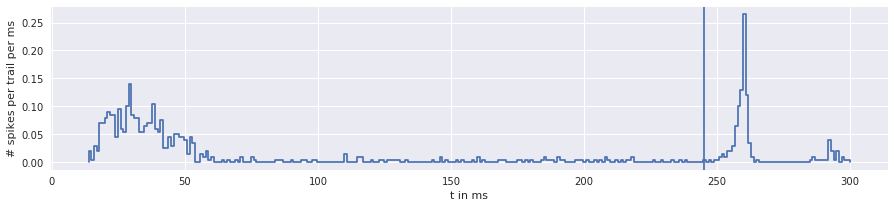

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15,3))
bins = I.temporal_binning(mdb['spike_times'])
I.histogram(bins, fig = fig)
fig.axes[-1].set_xlabel('t in ms')
fig.axes[-1].set_ylabel('# spikes per trail per ms')
fig.add_subplot(111).axvline(245)
fig

Usually, we discard the first 100ms of simulation since the cell needs that time to reach a "steady state". At 245ms, a C2 whisker stimulus occurs, followed by a strong evoked response at ~260 ms.

##### plot single voltage traces, mean and std

In [8]:
import dask
import matplotlib.pyplot as plt
mean = mdb['voltage_traces'].mean(axis = 0).compute(get = dask.multiprocessing.get)
std = mdb['voltage_traces'].std(axis = 0).compute(get = dask.multiprocessing.get)

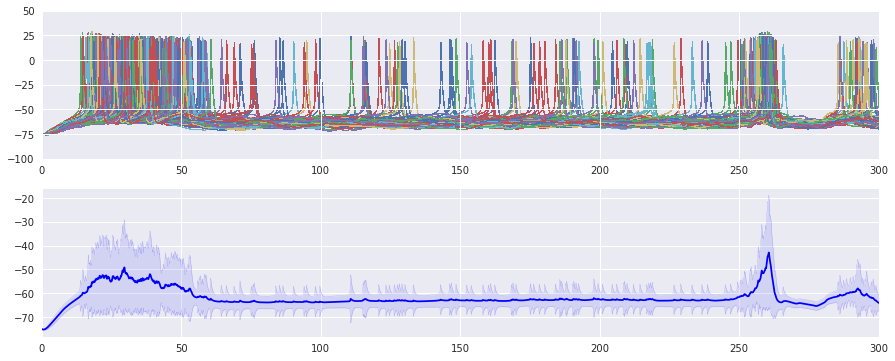

In [31]:
fig = plt.figure(figsize = (15,6))
I.manylines(mdb['voltage_traces'], fig = fig.add_subplot(211), axis = [0, 300, -100, 50])
I.average_std(mean, std, fig = fig.add_subplot(212))
fig.axes[-1].set_xlim(0,300)
fig

##### How many trails have a spike in the interval 245ms to 265 ms?

In [28]:
# here is what the spike times dataframe looks like
st = mdb['spike_times']
st.head()

,0,1,2,3,4,5
sim_trail_index,,,,,,
20170327-0745_seed122328974/000000,17.950,31.825,253.650,260.75,NaN,NaN
20170327-0745_seed122328974/000001,26.175,33.525,41.975,51.90,NaN,NaN
20170327-0745_seed122328974/000002,28.950,40.925,120.700,257.30,NaN,NaN
20170327-0745_seed122328974/000003,18.050,25.000,33.050,44.35,190.250,NaN
20170327-0745_seed122328974/000004,29.550,39.350,94.800,124.50,259.325,NaN


In [ ]:
# pandas provides a powerful syntax to calculate the number of trails (i.e. rows) to calculate the number
# of trails exhibiting a spike in the interval 245ms to 265ms.
st.apply(lambda x: ((x >= 245) & (x < 265)).any(), axis = 1).value_counts()

#### 1. Register cell morphology
From external resources (e.g. the NeuroMorph pipeline), you need a hoc-file with the dendrite morphology you want to place in the barrel cortex model. The coordinates in the hoc morphology file need to be choosen according to the coordinate system of the barrel cortex model. There is a morphology file in the getting_started subfolder, which is registered such that the cell is in the center of the C2 column. For the following steps, this morphology is used.

We create a new subfolder in our mdb object, where we put the hoc file and all other anatomical data

In [ ]:
mdb.create_managed_folder('anatomical_model')

In [9]:
mdb['anatomical_model']

'/home/abast/my_mdb/anatomical_model_9Fg6WT_'

Now, we copy the hoc file from the getting started folder into this folder (You can use the file explorer for this..)

In [5]:
import getting_started # getting_started.parent gives us the absolute path to the getting started folder
path_to_hoc = I.os.path.join(getting_started.parent, 'anatomical_constraints',\
                           '86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center.hoc')
I.shutil.copy(path_to_hoc, mdb['anatomical_model'])

#### 2. Generate anatomical model

To integrate the registered cell morphology in the barrel cortex model, we use the single_cell_input_mapper package. Its main method is `map_singlecell_inputs`. This method only needs two inputs: the path to the registered hoc morphology and the celltype. It will then create a subfolder containing the information about the position of the synapses and the presynaptic celltype attached to it.

Under the hood, 50 network realizations will be calculated. Out of these, the one that is closest to the average is choosen. The result is saved in the same folder as the hoc morphology. This takes about ** 4 hrs to compute **, therefore, we just compute 1 sample here.

In [11]:
celltype = 'L5tt'
path_to_registered_hoc_morphology = I.os.path.join(mdb['anatomical_model'], \
                                     '86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center.hoc')
# the singlecell input mapper produces a lot of printouts to stdout, which would crash this jupyter-notebook, 
# therefore silence it.
silent_map_singlecell_inputs = I.silence_stdout(I.map_singlecell_inputs)
%time silent_map_singlecell_inputs(path_to_registered_hoc_morphology, celltype, nrOfSamples=1)

CPU times: user 22min 36s, sys: 5.52 s, total: 22min 42s
Wall time: 22min 44s


##### Sidenote: how to parallelize it?
in case we would like to map the input on several cells in parallel, we could utilize dask to parallelize it using multiprocessing or a distributed cluster:

In [ ]:
# make the single cell mapper a delayed function
delayed_silent_map_singlecell_inputs = dask.delayed(silent_map_singlecell_inputs)

delayed_silent_map_singlecell_inputs is a function, which we can use exactly like I.map_singlecell_inputs. However, it returns a dask.delayed object and not the actual result. This delayed object contains a plan how to compute the result, but it is not computed yet. To compute it, the delayed object can be sent to a multiprocessing scheduler or dsitributed cluster, which can execute delayed objects in parallel. For more information see the [dask documentation](http://dask.pydata.org/en/latest/)

In [ ]:
# call it with the morphologies
delayeds = [silent_map_singlecell_inputs(morphology_paths[p], 'L5tt') for p in morphology_paths]
# bundle everything in one delayed object
delayeds = I.dask.delayed(delayeds)
# compute the result, e.g. with the multiprocessing scheduler
delayeds.compute(get = I.dask.multiprocessing.get)
# or with the distributed scheduler:
future = I.cluster('my_server:8787', set_as_default = False).compute(delayeds)

##### What does the result of the map_singlecell_inputs method look like?

The most important files are:
 - The  *_summary_*.csv file contains a summary statistics about the connectivity between all presynaptic populations and our neuron.
 - The *.con file and the *. syn file are the relevant output of the SingleCellMapper for simulations of evoked activity.

The con file maps between presynaptic cells and synapses:

In [16]:
con_file_path = I.glob.glob(I.os.path.join(mdb['anatomical_model'], '*', '*.con'))[0]

In [23]:
with open(con_file_path) as f:
    print f.read()[:300]

# Anatomical connectivity realization file; only valid with synapse realization:
# 86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_synapses_20171021-2153_2787.syn
# Type - cell ID - synapse ID

L6cc_A3	0	0
L6cc_A3	1	1
L6cc_A3	2	2
L6cc_A3	3	3
L6cc_A3	4	4
L6cc_A3	5	5
L6cc_A3	6	6



The .syn file specifies the exact position of each synapse on the hoc morphology:

In [21]:
syn_file_path = I.glob.glob(I.os.path.join(mdb['anatomical_model'], '*', '*.syn'))[0]

In [24]:
with open(syn_file_path) as f:
    print f.read()[:300]

# Synapse distribution file
# corresponding to cell: 86_L5_86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center
# Type - section - section.x

SymLocal3_C1	148	0.993649889038
SymLocal3_C1	38	0.126538357522
SymLocal3_C1	51	0.300634863007
SymLocal3_C3	133	0.919752699752
SymLocal3_C3	13


#### 4. Activate synapses
In the previous step, the synapse location on the hoc morphology was specified. Now we need to activate the synapses according to experimental data. Here, we generate a parameter file specifying the summary statistics of the activation of the presynaptic cells with 1ms resolution.

##### specify parameters

In [11]:
I.create_evoked_network_parameter?

In [12]:
mdb.create_managed_folder('functional_model')

'/home/abast/my_mdb/functional_model_TTphUW_'

In [23]:
import getting_started
ongoingTemplateParamName = I.os.path.join(getting_started.parent, 'functional_constraints/ongoing_activity/ongoing_activity_celltype_template_exc_conductances_fitted.param')
assert(I.os.path.exists(ongoingTemplateParamName))
# syn_file_path: see above
# con_file_path: see above 
cellNumberFileName = I.os.path.join(I.os.path.dirname(con_file_path), 'NumberOfConnectedCells.csv')
#simulate C2 stimulus. Since out cell is located in C2center, this is a principal whisker stimulation scenario.
whisker = 'C2' 
evoked_param_name = I.os.path.join(mdb['functional_model'], 'network.param')
I.create_evoked_network_parameter(ongoingTemplateParamName, cellNumberFileName, syn_file_path, \
                                  con_file_path, whisker, evoked_param_name)    

*************
creating network parameter file from template /nas1/Data_arco/project_src/in_silico_framework/getting_started/functional_constraints/ongoing_activity/ongoing_activity_celltype_template_exc_conductances_fitted.param
*************


##### what does the result look like?

In [24]:
with open(evoked_param_name) as f:
    print f.read()[:4100]

{
  "info": {
    "date": "11Feb2015",
    "name": "ongoing_activity_up_state_anatomical_map_20150211-1430_22780",
    "author": "regger",
  },
  "network": {
    "L45Peak_D1": {
      "synapses": {
        "releaseProb": 0.25,
        "distributionFile": "/home/abast/my_mdb/anatomical_model_9Fg6WT_/86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_synapses_20171021-2153_2787/86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_synapses_20171021-2153_2787.syn",
        "receptors": {
          "gaba_syn": {
            "threshold": 0.0,
            "delay": 0.0,
            "parameter": {
              "decaytime": 20.0,
              "risetime": 1.0,
              "decaygaba": 1.0,
              "e": -80.0,
              "facilgaba": 0.0,
            },
            "weight": 1.0,
          },
        },
        "connectionFile": "/home/abast/my_mdb/anatomical_model_9Fg6WT_/86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_synaps

This file contains the activation pattern of every presynaptic population providing input to the single cell we want to simulate. One "population" in this case is one celltype in one column. Examples are: L45Peak_D1, L5tt_D2, L5tt_C2, VPM_C1, ...

In this file all the parameters necessary to constrain the timedependent acitvity of the synapses mapped onto the neuron are specified:
 - synapses --> releaseProb: chance that synapse gets activated if presynaptic cell gets activated
 - synapses --> distributionFile: pointing to the .syn file generated in the anatomical network mapping above
 - network --> [population] --> celltype --> pointcell --> spiketrain: mean ongoing frequency of the presynaptic populations
 - network --> [population] --> celltype --> pointcell --> probabilities: PSTH of evoked activity (will be added on top of ongoing activity)
 - network --> [population] --> celltype --> pointcell --> offset: timepoint at which the evoked activity starts
 - ...
 

## Determine channel densities such that the cell exhibits certain properties measured in slice data

Currently, the parameters are determined using a MOO approach. The result is writen manually in the cell parameter file:

In [ ]:
'/nas1/Data_arco/project_src/in_silico_framework/getting_started/biophysical_constraints/86_CDK_20041214_BAC_run5_soma_Hay2013_C2center_apic_rec.param

In [28]:
cell_parameter_file = I.os.path.join(getting_started.parent, 'biophysical_constraints', \
                                     '86_CDK_20041214_BAC_run5_soma_Hay2013_C2center_apic_rec.param')
with open(cell_parameter_file) as f:
    print f.read()[:1000]


{	
	"info":
	{
		"name":		"hay_2011_dend_test", 
		"author":	"regger",
		"date": 	"15Oct2014",
	},
	
	"NMODL_mechanisms":
	{
        "channels": "/",
	},
	
	"mech_globals":
	{
	},
	
	"neuron":
	{
		"filename": "/nas1/Data_arco/project_src/in_silico_framework/getting_started/anatomical_constraints/86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center.hoc",
		
		"Soma":
		{
			"properties":
			{
				"Ra": 100.0,
				"cm": 1.0,
                
                "ions":
                {
                    "ek": -85.0,
                    "ena": 50.0,
                },
			},
			
			"mechanisms":
			{
				"global":
				{
					
				},
				
				"range":
				{
                    "pas":
                    {
                        "spatial": "uniform",
                        "g": 0.0000326,
                        "e": -90,
                    },
                    "Ca_LVAst":
                    {
                        "spatial": "uniform",
                        "gCa_

### run the simulation

In [31]:
evoked_param_name # specified above
cell_parameter_file  #specified above
dir_prefix = mdb.create_managed_folder('simrun') #results are put here in a "results" subfolder
nSweeps= 10 # number of consecutive mounte carlo simulations per process
nprocs = 20 # number of processes simulating in parallel
tStop = 300 # stop the simulation at 300ms
silent = True # suppress output to stdout (disable this for debug purposes)

In [33]:
%time d = I.simrun_run_new_simulations(cell_parameter_file, evoked_param_name, dirPrefix=dir_prefix, nSweeps=nSweeps, nprocs=nprocs, tStop=tStop, silent=silent)
d

CPU times: user 24 ms, sys: 12 ms, total: 36 ms
Wall time: 43.5 ms


Delayed('lambda-44a387c7-774d-4ad0-8bdb-a85585442ee5')

The result is a dask delayed object, in which a **plan** how to compute the result is stored. To compute it, call `compute`. The get keyword allows to specify a scheduler, here the multiprocessing scheduler is used. To run it on a cluster, an instance of `distributed.Client` could be used.

In [35]:
with I.dask.diagnostics.ProgressBar():
    d.compute(get = I.dask.multiprocessing.get) # run the simulation using the multiprocessing scheduler

[                                        ] | 0% Completed |  9min 17.5s


KeyboardInterrupt: 

### load simulation results in database to make them accessible in python

In [4]:
import Interface as I
mdb = I.ModelDataBase(os.path.join(getting_started_files, 'mdb')) #specify home folder of database

In [4]:
I.mdb_init_simrun_general.init(mdb, os.path.join(getting_started_files, 'results'))

---building data base core---
generate filelist ...
generate voltage traces dataframe...
[########################################] | 100% Completed |  0.6s
generate unambigous indices ...
[########################################] | 100% Completed |  0.8s
generate metadata ...
add divisions to voltage traces dataframe
---moving parameter files---
find unique parameterfiles
[########################################] | 100% Completed |  3.5s
move parameterfiles
[########################################] | 100% Completed |  0.1s
move parameterfiles
[########################################] | 100% Completed |  0.1s
---building synapse activation dataframe---
counting commas
[########################################] | 100% Completed |  0.3s
14
generate dataframe
[########################################] | 100% Completed |  0.1s
save dataframe
---building cell activation dataframe---
counting commas
[########################################] | 100% Completed |  0.3s
17
generate dataframe

The mdb object can be used like a dictionary. The database contains dask dataframes giving access to the simulation data.

In [89]:
mdb.keys()

['Vm_distal',
 'Vm_proximal',
 'burst_times',
 'cell_activation',
 'dendritic_voltage_traces_keys',
 'file_list',
 'metadata',
 'parameterfiles',
 'parameterfiles_cell_folder',
 'parameterfiles_network_folder',
 'sim_trail_index',
 'simresult_path',
 'spike_times',
 'synapse_activation',
 'voltage_traces']

In [88]:
mdb['synapse_activation'].head()

[########################################] | 100% Completed |  0.1s


,synapse_type,synapse_ID,soma_distance,section_ID,section_pt_ID,dendrite_label,0,1,2,3,4,5,6,7
sim_trail_index,,,,,,,,,,,,,,
20170327-0745_seed122328974/000000,L1_C1,6,1417.471240,47,9,ApicalDendrite,208.348580,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20170327-0745_seed122328974/000000,L1_C1,18,1508.620514,50,63,ApicalDendrite,240.685555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20170327-0745_seed122328974/000000,L1_C1,21,1494.761607,49,48,ApicalDendrite,174.886361,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20170327-0745_seed122328974/000000,L1_C1,25,1389.264410,50,7,ApicalDendrite,228.604036,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20170327-0745_seed122328974/000000,L1_C2,9,1423.024481,74,5,ApicalDendrite,74.905120,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### plot the PSTH

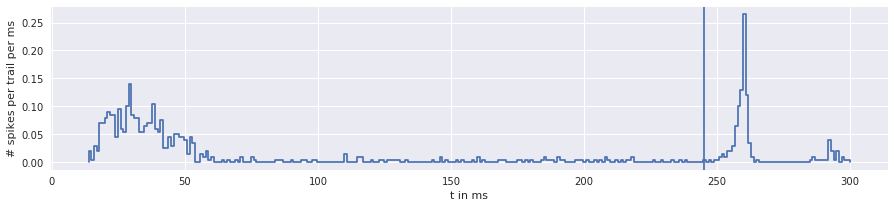

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15,3))
bins = I.temporal_binning(mdb['spike_times'])
I.histogram(bins, fig = fig)
fig.axes[-1].set_xlabel('t in ms')
fig.axes[-1].set_ylabel('# spikes per trail per ms')
fig.add_subplot(111).axvline(245)
fig

Usually, we discard the first 100ms of simulation since the cell needs that time to reach a "steady state". At 245ms, a C2 whisker stimulus occurs, followed by a strong evoked response at ~260 ms.

##### plot single voltage traces, mean and std

In [8]:
import dask
import matplotlib.pyplot as plt
mean = mdb['voltage_traces'].mean(axis = 0).compute(get = dask.multiprocessing.get)
std = mdb['voltage_traces'].std(axis = 0).compute(get = dask.multiprocessing.get)

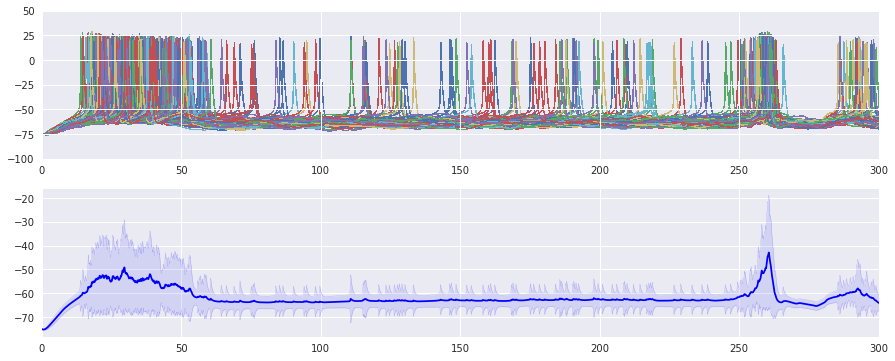

In [31]:
fig = plt.figure(figsize = (15,6))
I.manylines(mdb['voltage_traces'], fig = fig.add_subplot(211), axis = [0, 300, -100, 50])
I.average_std(mean, std, fig = fig.add_subplot(212))
fig.axes[-1].set_xlim(0,300)
fig

##### How many trails have a spike in the interval 245ms to 265 ms?

In [28]:
# here is what the spike times dataframe looks like
st = mdb['spike_times']
st.head()

,0,1,2,3,4,5
sim_trail_index,,,,,,
20170327-0745_seed122328974/000000,17.950,31.825,253.650,260.75,NaN,NaN
20170327-0745_seed122328974/000001,26.175,33.525,41.975,51.90,NaN,NaN
20170327-0745_seed122328974/000002,28.950,40.925,120.700,257.30,NaN,NaN
20170327-0745_seed122328974/000003,18.050,25.000,33.050,44.35,190.250,NaN
20170327-0745_seed122328974/000004,29.550,39.350,94.800,124.50,259.325,NaN


### model data base in more detail

We can use the mdb like a dictionary. However, all data will be instantly saved to / loaded from disk:

In [22]:
mdb['something'] = 'some text i want to save'

In [23]:
mdb['something']

'some text i want to save'

The model data base also stores metadata for each item, which is tightly integrated with the git version control:

In [26]:
mdb.metadata['something']

defaultdict(<function model_data_base.model_data_base.<lambda>>,
            {'dirty': True,
             'dumper': 'to_cloudpickle',
             'error': None,
             'full-revisionid': '6b077e6bdc0f559d05de7b969191a622b1be960b',
             'metadata_creation_time': 'together_with_new_key',
             'time': (2017, 10, 21, 13, 7, 28, 5, 294, -1),
             'version': 'v0.0.1+66.g6b077e6.dirty'})

In [ ]:
# Below is the old version

# Setup

### Get example data
Clone this repository to get all necessary data for a small example testcase: `git clone https://github.com/abast/neurosim_getting_started.git`

Adapt the path in the cell below and execute it.

In [7]:
import os, dask
getting_started_files = '/home/abast/test/neurosim_getting_started/getting_started_files/' #change that path for your cloned repository

### If you only want to run current injection simulations using our L5tt model, please do the following:
1. download and install Anaconda 2.7 https://www.continuum.io/Downloads
2. install neuron such that you can import it as python module. Version 7.4 has been tested, newer versions are likely to work. A detailed installation guide can be found at http://www.davison.webfactional.com/notes/installation-neuron-python/
3. install sumatra: `pip install sumatra`
4. clone the single_cell_parser git respository: `git clone https://github.com/abast/single_cell_parser.git`
5. Add the resulting folder single_cell_parser to the PYTHONPATH variable: `export PYTHONPATH=$PYTHONPATH:/my/freshly/cloned/repository`
6. make sure you can import that module in python: `import single_cell_parser as scp`
       
Adapt the following paths (please specify absolute paths):
- Open the file `neurosim_getting_started/getting_started_files/86_CDK_20041214_BAC_run5_soma_Hay2013_C2center_apic_rec.param`:
    - "NMODL_mechanisms" --> "channels": has to point to the absolute path of the mechanism subfolder in the single_cell_parser_module
    - "neuron" --> "filename": has to point to the neuron morphology in neurosim_getting_started/getting_started_files
    - "sim" --> recordingSites: has to point to `apical_proximal_distal_rec_sites.landmarkAscii` in neurosim_getting_started/getting_started_files
- Open the file `neurosim_getting_started/getting_started_files/functional_constraints/ongoing_activity/ongoing_activity_celltype_template_exc_conductances_fitted.param'`
    - NMODL_mechanisms --> synapses: has to point to the folder neurosim_getting_started/getting_started_files/mechanisms/channels
    - NMODL_mechanisms --> VecStim: has to point to the folder neurosim_getting_started/getting_started_files/mechanisms/netcon

If you want to try out the simulator immediately, jump to "How to simulate current injections"

##### What are these packages doing?
 - sumatra: we use it to read and write to parameterfiles
 - single_cell_parser: module written by Robert Egger wrapping around neuron. It provides a high level interface specifically build to simulate full compartmental models and synaptic input.

### If you also want to run simulations with synaptic input, please install in addition:
1. install pandas from git master: `pip install -U git+https://github.com/pandas-dev/pandas.git` (it has to contain this commit: https://github.com/pandas-dev/pandas/pull/15493)
2. dask 0.14: `conda install dask==0.14`
3. distributed 1.15.2: `conda install distributed=1.15.2` (optional, if you want to run simulations on a cluster)
4. seaborn: conda install seaborn
4. Clone SingleCellInputMapper: `git clone https://github.com/abast/SingleCellInputMapper.git`
5. Unzip the file `SingleCellinputMapper/barrel_cortex.7z such that the path SingleCellinputMapper/barrel_cortex/PST exists`
6. Clone the model_data_base repository: `https://github.com/abast/model_data_base.git`
7. Add the repositories to the PYTHONPATH variable

Adapt the following paths:
8. Open the file model_data_base/simrun2/seed_manager and adjust the variable `path`. This will specify the location where used seeds are saved. Any location where you have write access is suitable.
2. Open the file SingleCellinputMapper/map_singlecell_inputs and change the line `prefix =  ...` such that it points to the barrel_cortex folder that you have unzipped above.
3. Open the file SingleCellinputMapper/evoked_network_param_from_template.py and change the variable `evokedPrefix = ...` such that it points to the folder `neurosim_getting_started/getting_started_files/functional_constraints/evoked_activity/PW_SuW_RF_CDK`

##### what are these packages doing?
 - pandas is a library for panel data analysis. It is the standard format in the database for simulation results.
 - dask is a python library for dynamic task scheduling and parallel numpy/pandas computations, which allows to use the pandas data structure out of core
 - distributed allows to execute dask graphs on a distributed system
 - SingleCellInputMapper maps synapses on a single cell and thereby integrates it in the barrel cortex model
 - model_data base contains modules to run simulations and analyze the result in parallel. It also uses dask for parallelization.


# How to simulate synaptic input